### data set
https://www.kaggle.com/retailrocket/ecommerce-dataset

In [1]:
import numpy as np
import pandas as pd

### load data

In [4]:
events = pd.DataFrame.from_csv('./data/test_events_1.csv')
item_properties =  pd.DataFrame.from_csv('./data/item_properties_part1.csv').append(pd.DataFrame.from_csv('./data/item_properties_part2.csv'))
category_tree = pd.DataFrame.from_csv('./data/category_tree.csv')

In [5]:
events.shape[0]

542078

In [6]:
events.head()

,index,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,event_type,session_transation_type
0,2655436,1442004589439,0,view,285930,-1,NaN,NaN,1,0,0
1,2655495,1442004759591,0,view,357564,-1,2.835867,2.835867,1,0,0
2,2655555,1442004917175,0,view,67045,-1,2.626400,2.626400,1,0,0
3,2731107,1442352267167,4,view,177677,-1,NaN,NaN,2,0,0
4,2422269,1440914628202,6,addtocart,65273,-1,NaN,NaN,3,1,0


In [4]:
events.head()

,index,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,session_type
0,2024720,1438969904567,2,view,325215,-1,NaN,NaN,1.0,2.0
1,2024760,1438970013790,2,view,325215,-1,1.820383,1.820383,1.0,2.0
2,2024834,1438970212664,2,view,259884,-1,3.314567,3.314567,1.0,2.0
3,2024945,1438970468920,2,view,216305,-1,4.270933,4.270933,1.0,2.0
4,2025140,1438970905669,2,view,342816,-1,7.279150,7.279150,1.0,2.0


In [7]:
item_properties.shape

(20275902, 3)

In [19]:
item_properties.reset_index(inplace=True)

In [20]:
item_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [9]:
category_tree.shape

(1669, 1)

In [10]:
category_tree.head()

,parentid
categoryid,
1016,213.0
809,169.0
570,9.0
1691,885.0
536,1691.0


In [11]:
category_tree.parentid.unique().shape[0]

363

In [12]:
category_tree.index.value_counts().shape[0]

1669

In [13]:
#выберем из item_properties категории обьектов

In [21]:
categories = item_properties.loc[item_properties.property =='categoryid'].sort_values([ 'itemid','timestamp'], ascending = [True,False])

In [22]:
categories.value.unique().shape

(1242,)

In [23]:
categories.head()

,timestamp,itemid,property,value
19220984,1431226800000,0,categoryid,209
8428979,1431226800000,1,categoryid,1114
9157980,1431226800000,2,categoryid,1305
3828355,1433041200000,3,categoryid,1171
19767463,1431831600000,4,categoryid,1038


In [24]:
events.shape[0] - events.loc[events.itemid.isin(categories.itemid.unique())].shape[0]

53757

In [25]:
#функция определиния катеогории объекта
def get_cat(timestamp,itemid):
    result = np.nan
    i_ = categories.loc[(categories.itemid == itemid)&(categories.timestamp <= timestamp)]
    if i_.shape[0] != 0:
        result = int(i_.iloc[0].value)
    return result

In [26]:
e__ = np.array(events[['timestamp','itemid']])

In [27]:
e__.shape

(542078, 2)

In [28]:
#Внимание!!! Wall time: 51min 12s

In [29]:
%%time
cat = []
for i in e__:
    cat.append(get_cat(i[0],i[1]))

CPU times: user 22min 15s, sys: 7.03 s, total: 22min 22s
Wall time: 22min 26s


In [30]:
events['item_cat'] = cat

In [31]:
def get_cat_list(categoryid):
    result = [categoryid]
    cat = categoryid
    while True:
        #print(cat)
        if np.isnan(cat):
            break
        cat = category_tree.loc[category_tree.index == int(cat)].iloc[0]['parentid']
        result.append(cat)
    return result

def item_distance(cat1, cat2):
    if np.isnan(cat1) and np.isnan(cat2) :
        return 0
    
    if np.isnan(cat1) or np.isnan(cat2) :
        if np.isnan(cat1):
            return len(get_cat_list(cat2))
        if np.isnan(cat2):
            return len(get_cat_list(cat1))
        
    if cat1 == cat2 :
        return 0
        
    cat_list1 = get_cat_list(cat1)
    cat_list2 = get_cat_list(cat2)
    cat_list1.reverse()
    cat_list2.reverse()

    i = 0
    result = []
    while True:
        if (i >= len(cat_list1) or i >= len(cat_list2)):
            break
        result.append(cat_list1[i]-cat_list2[i])
        i = i +1
    r = 0

    for r_ in result:
        if r_ != 0:
            break
        r = r + 1
    return (len(cat_list1)- r + len(cat_list2)-r)
    

In [32]:
%%time

d_ = np.zeros(events.shape[0])
session = '0'
dist = events.iloc[0]['item_cat']
for index, row in events.iterrows():
    if session != row['ssid']:
        dist = row['item_cat']
    d_[index] = item_distance(row['item_cat'],dist)
    dist = row['item_cat'] 
    session = row['ssid']

CPU times: user 2min 21s, sys: 537 ms, total: 2min 22s
Wall time: 2min 22s


In [33]:
events['item_cat_dist'] = d_

In [34]:
events.head(10)

,index,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,event_type,session_transation_type,item_cat_dist,item_cat
0,2655436,1442004589439,0,view,285930,-1,NaN,NaN,1,0,0,0.0,1188.0
1,2655495,1442004759591,0,view,357564,-1,2.835867,2.835867,1,0,0,8.0,256.0
2,2655555,1442004917175,0,view,67045,-1,2.626400,2.626400,1,0,0,8.0,333.0
3,2731107,1442352267167,4,view,177677,-1,NaN,NaN,2,0,0,0.0,NaN
4,2422269,1440914628202,6,addtocart,65273,-1,NaN,NaN,3,1,0,0.0,342.0
5,2422579,1440916778318,6,view,253615,-1,35.835267,NaN,4,0,0,0.0,342.0
6,2422581,1440916823805,6,view,344723,-1,0.758117,0.758117,4,0,0,0.0,342.0
7,2422674,1440917649385,6,view,344723,-1,13.759667,13.759667,4,0,0,0.0,342.0
8,2422699,1440917793838,6,view,344723,-1,2.407550,2.407550,4,0,0,0.0,342.0
9,2437154,1440991285697,6,view,344723,-1,1224.864317,NaN,5,0,0,0.0,342.0


In [35]:
##уберем лишние данные и "причешем" дата сет

In [36]:
events['event_type'] = events.event.copy()

In [37]:
events.event_type = events.event_type.replace({'view': 0, 'addtocart': 1, 'transaction': 2})

In [38]:
events['event_type'] = events['event_type'].astype(int)

In [40]:
#events['session_type'] = events['session_type'].fillna(-1).astype(int)

In [41]:
events['ssid'] = events['ssid'].astype(int)

In [42]:
events.head()

,index,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,event_type,session_transation_type,item_cat_dist,item_cat
0,2655436,1442004589439,0,view,285930,-1,NaN,NaN,1,0,0,0.0,1188.0
1,2655495,1442004759591,0,view,357564,-1,2.835867,2.835867,1,0,0,8.0,256.0
2,2655555,1442004917175,0,view,67045,-1,2.626400,2.626400,1,0,0,8.0,333.0
3,2731107,1442352267167,4,view,177677,-1,NaN,NaN,2,0,0,0.0,NaN
4,2422269,1440914628202,6,addtocart,65273,-1,NaN,NaN,3,1,0,0.0,342.0


### Итоговый дата сет

In [43]:
#количество событий в сете для классификации
events.shape[0]

542078

In [44]:
events.head()

,index,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,event_type,session_transation_type,item_cat_dist,item_cat
0,2655436,1442004589439,0,view,285930,-1,NaN,NaN,1,0,0,0.0,1188.0
1,2655495,1442004759591,0,view,357564,-1,2.835867,2.835867,1,0,0,8.0,256.0
2,2655555,1442004917175,0,view,67045,-1,2.626400,2.626400,1,0,0,8.0,333.0
3,2731107,1442352267167,4,view,177677,-1,NaN,NaN,2,0,0,0.0,NaN
4,2422269,1440914628202,6,addtocart,65273,-1,NaN,NaN,3,1,0,0.0,342.0


In [45]:
events = events.sort_values(['ssid', 'timestamp'], ascending=[True, True])

In [ ]:
#сгруппируем сессии

In [49]:
%%time
sessions_ =  events[['ssid',
                     'delta1',
                     'itemid',
                     #'session_type',
                     'item_cat',
                     'event_type',
                     'item_cat_dist',
                     'session_transation_type'
                     ]].groupby('ssid').agg(['mean','count','sum','max','nunique'])

CPU times: user 655 ms, sys: 173 ms, total: 829 ms
Wall time: 895 ms


In [50]:
sessions = sessions_

In [51]:
sessions_.head()

delta1                                             itemid        \
          mean count        sum        max nunique           mean count   
ssid                                                                      
1     2.731133     2   5.462267   2.835867       2  236846.333333     3   
2          NaN     0        NaN        NaN       0  177677.000000     1   
3          NaN     0        NaN        NaN       0   65273.000000     1   
4     5.641778     3  16.925333  13.759667       3  321946.000000     4   
5          NaN     0        NaN        NaN       0  344723.000000     1   

                                ...   item_cat_dist                           \
          sum     max nunique   ...            mean count   sum  max nunique   
ssid                            ...                                            
1      710539  357564       3   ...        5.333333     3  16.0  8.0       2   
2      177677  177677       1   ...        0.000000     1   0.0  0.0       1   
3       65273   65273       1   ...        0.000000     1   0.0  0.0       1   
4     1287784  344723       2   ...        0.000000     4   0.0  0.0       1   
5      344723  344723       1   ...        0.000000     1   0.0  0.0       1   

     session_transation_type                        
                        mean count sum max nunique  
ssid                                                
1                          0     3   0   0       1  
2                          0     1   0   0       1  
3                          0     1   0   0       1  
4                          0     4   0   0       1  
5                          0     1   0   0       1  

[5 rows x 30 columns]

In [52]:
sessions.head(5)

delta1                                             itemid        \
          mean count        sum        max nunique           mean count   
ssid                                                                      
1     2.731133     2   5.462267   2.835867       2  236846.333333     3   
2          NaN     0        NaN        NaN       0  177677.000000     1   
3          NaN     0        NaN        NaN       0   65273.000000     1   
4     5.641778     3  16.925333  13.759667       3  321946.000000     4   
5          NaN     0        NaN        NaN       0  344723.000000     1   

                                ...   item_cat_dist                           \
          sum     max nunique   ...            mean count   sum  max nunique   
ssid                            ...                                            
1      710539  357564       3   ...        5.333333     3  16.0  8.0       2   
2      177677  177677       1   ...        0.000000     1   0.0  0.0       1   
3       65273   65273       1   ...        0.000000     1   0.0  0.0       1   
4     1287784  344723       2   ...        0.000000     4   0.0  0.0       1   
5      344723  344723       1   ...        0.000000     1   0.0  0.0       1   

     session_transation_type                        
                        mean count sum max nunique  
ssid                                                
1                          0     3   0   0       1  
2                          0     1   0   0       1  
3                          0     1   0   0       1  
4                          0     4   0   0       1  
5                          0     1   0   0       1  

[5 rows x 30 columns]

In [53]:
sessions_['event_type']['nunique'].value_counts()

1    356490
2      6066
3      2224
Name: nunique, dtype: int64

In [54]:
sessions = sessions.reset_index()

In [55]:
sessions['count'] = sessions['itemid']['count']

In [56]:
sessions['items_unique'] = sessions['itemid']['nunique']

In [57]:
sessions = sessions.drop(['itemid'],axis=1)

/Users/sattarov-a/Documents/DEV/Python/NETOLOGY_DS/anaconda/envs/DS1/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  """Entry point for launching an IPython kernel.


In [61]:
sessions['sessions_len'] = sessions['delta1']['sum']
sessions['delta_mean'] = sessions['delta1']['mean']

In [ ]:

# 0.25    0.917700
# 0.50    2.906800
# 0.75    9.170033

In [63]:
sessions['ssid_type'] = 0

In [69]:
sessions.loc[sessions['sessions_len'] <= 0.917700,['ssid_type']] = 0
sessions.loc[(sessions['sessions_len'] > 0.917700)&(sessions['sessions_len'] <= 9.170033),['ssid_type']] = 1
sessions.loc[sessions['sessions_len'] > 9.170033,['ssid_type']] = 2

In [70]:
sessions = sessions.drop(['delta1'],axis=1)

/Users/sattarov-a/Documents/DEV/Python/NETOLOGY_DS/anaconda/envs/DS1/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  """Entry point for launching an IPython kernel.


In [71]:
sessions['categories'] = sessions['item_cat']['nunique']
sessions = sessions.drop(['item_cat'],axis=1)

/Users/sattarov-a/Documents/DEV/Python/NETOLOGY_DS/anaconda/envs/DS1/lib/python3.6/site-packages/ipykernel_launcher.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  


In [72]:
sessions['event_type_nu'] = sessions['event_type']['nunique']
sessions = sessions.drop(['event_type'],axis=1)

/Users/sattarov-a/Documents/DEV/Python/NETOLOGY_DS/anaconda/envs/DS1/lib/python3.6/site-packages/ipykernel_launcher.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  


In [73]:
sessions['dist1_mean'] = sessions['item_cat_dist']['mean']
sessions['dist1_max'] = sessions['item_cat_dist']['max']
sessions['dist1_sum'] = sessions['item_cat_dist']['sum']
sessions = sessions.drop(['item_cat_dist'],axis=1)

/Users/sattarov-a/Documents/DEV/Python/NETOLOGY_DS/anaconda/envs/DS1/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  after removing the cwd from sys.path.


In [74]:
sessions['target'] = sessions['session_transation_type']['max']

In [75]:
sessions = sessions.drop(['session_transation_type'],axis=1)

/Users/sattarov-a/Documents/DEV/Python/NETOLOGY_DS/anaconda/envs/DS1/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  """Entry point for launching an IPython kernel.


In [76]:
#!!
sessions['event_type_nu'] = sessions['event_type_nu'].replace({1: 0, 2: 1, 3: 1})

In [77]:
sessions['target'].value_counts()

0    361828
1      2952
Name: target, dtype: int64

In [78]:
sessions.shape[0]

364780

In [79]:
sessions.loc[sessions.target > 0].shape[0]

2952

In [80]:
sessions.head()

,ssid,count,items_unique,sessions_len,delta_mean,ssid_type,categories,event_type_nu,dist1_mean,dist1_max,dist1_sum,target
,,,,,,,,,,,,
0,1,3,3,5.462267,2.731133,1,3,0,5.333333,8.0,16.0,0
1,2,1,1,NaN,NaN,0,0,0,0.000000,0.0,0.0,0
2,3,1,1,NaN,NaN,0,1,0,0.000000,0.0,0.0,0
3,4,4,2,16.925333,5.641778,2,1,0,0.000000,0.0,0.0,0
4,5,1,1,NaN,NaN,0,1,0,0.000000,0.0,0.0,0


In [81]:
sessions_ = sessions.loc[sessions['count'] > 1]
# выкинем единичные сессии

In [82]:
sessions_.shape[0]

76224

In [83]:
data = sessions_.drop(['ssid'], axis=1)

In [84]:
#матрица корреляциЙ между признаками
data.corr()

,,count,items_unique,sessions_len,delta_mean,ssid_type,categories,event_type_nu,dist1_mean,dist1_max,dist1_sum,target
,,,,,,,,,,,,
count,,1.000000,0.921024,0.608265,-0.061773,0.287868,0.593901,0.159799,0.201090,0.274547,0.741726,0.106776
items_unique,,0.921024,1.000000,0.512803,-0.067653,0.219857,0.612625,0.029351,0.256638,0.314680,0.755494,0.009230
sessions_len,,0.608265,0.512803,1.000000,0.507260,0.611799,0.524832,0.117250,0.213656,0.257400,0.505773,0.122836
delta_mean,,-0.061773,-0.067653,0.507260,1.000000,0.625988,-0.012028,-0.057741,0.023297,0.011666,-0.012467,-0.001522
ssid_type,,0.287868,0.219857,0.611799,0.625988,1.000000,0.180930,0.094922,0.163955,0.211544,0.171096,0.119074
categories,,0.593901,0.612625,0.524832,-0.012028,0.180930,1.000000,0.081940,0.572177,0.546043,0.851116,0.061417
event_type_nu,,0.159799,0.029351,0.117250,-0.057741,0.094922,0.081940,1.000000,0.008137,0.054036,0.070130,0.555798
dist1_mean,,0.201090,0.256638,0.213656,0.023297,0.163955,0.572177,0.008137,1.000000,0.928695,0.489877,0.004980
dist1_max,,0.274547,0.314680,0.257400,0.011666,0.211544,0.546043,0.054036,0.928695,1.000000,0.458162,0.027206


In [85]:
data = sessions_.drop(['ssid','target'], axis=1)
target = sessions_.target

In [91]:
from sklearn.externals import joblib

In [92]:
filename = 'rf.joblib.pkl'

In [93]:
rf = joblib.load(filename)

In [94]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [95]:
y_pred = rf.predict(data)

In [96]:
y_test = target

In [97]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [98]:
accuracy_score(y_test, y_pred)

0.94539777497900923

In [99]:
confusion_matrix(y_test, y_pred)

array([[69705,  3750],
       [  412,  2357]])

In [100]:
target_names = ['class 0', 'class 1']
print(classification_report( y_test,y_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.99      0.95      0.97     73455
    class 1       0.39      0.85      0.53      2769

avg / total       0.97      0.95      0.96     76224



In [103]:
# важность фич

In [107]:
from sklearn.metrics import precision_recall_curve, roc_curve ,auc, roc_auc_score

In [108]:
predictions = rf.predict_proba(data)

In [113]:
import matplotlib.pyplot as plt
import seaborn as sn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sattarov-a/Documents/DEV/Python/NETOLOGY_DS/anaconda/envs/DS1/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


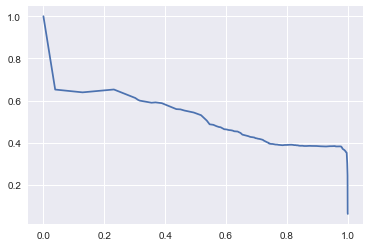

In [114]:
pr, re, thres = precision_recall_curve(y_test, predictions[:, 1] )
plt.plot( re, pr )
# построим precision - recall кривую

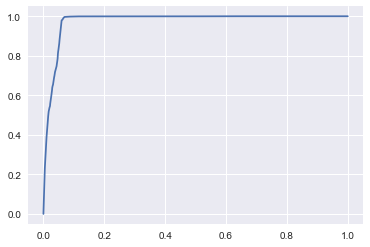

In [115]:
fpr, tpr, thres = roc_curve(y_test, predictions[:, 1] )
plt.plot( fpr, tpr )
# построим ROC-кривую (Receiver Operating Characteristic)

In [116]:
roc_auc_score( y_test, predictions[:, 1] )

0.97605491470260641

In [117]:
auc( fpr, tpr )

0.97605491470260641

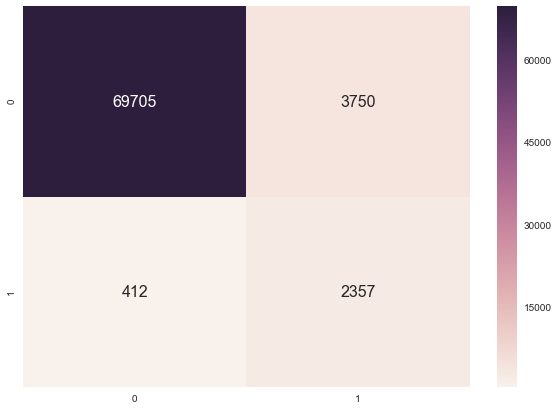

In [118]:
plt.figure(figsize = (10,7))
sn.set(font_scale=1)#for label size
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True,annot_kws={"size": 16} ,fmt="d")# font size